# Manifold Output Explorer

Point `domain` at any domain's output directory to load and explore.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 100

# === POINT AT ANY DOMAIN ===
domain = Path.home() / 'domains/cmapss/FD_004/train/output'
# domain = Path.home() / 'domains/rossler/train/output'
# domain = Path.home() / 'domains/calce/output'

## Load All Parquet Files

In [2]:
files = {}
for f in sorted(domain.rglob('*.parquet')):
    name = f.stem
    files[name] = pd.read_parquet(f)
    print(f'{name:40s} {str(files[name].shape):>16s}  {f.relative_to(domain)}')

print(f'\n{len(files)} files loaded')

breaks                                        (46448, 10)  cohort/cohort_dynamics/breaks.parquet
ftle                                           (5976, 14)  cohort/cohort_dynamics/ftle.parquet
ftle_backward                                  (5976, 14)  cohort/cohort_dynamics/ftle_backward.parquet
ftle_field                                      (2208, 8)  cohort/cohort_dynamics/ftle_field.parquet
ftle_rolling                                   (8640, 13)  cohort/cohort_dynamics/ftle_rolling.parquet
geometry_dynamics                              (9399, 14)  cohort/cohort_dynamics/geometry_dynamics.parquet
lyapunov                                        (5976, 7)  cohort/cohort_dynamics/lyapunov.parquet
persistent_homology                             (110, 14)  cohort/cohort_dynamics/persistent_homology.parquet
ridge_proximity                                (4584, 12)  cohort/cohort_dynamics/ridge_proximity.parquet
thermodynamics                                   (249, 7)  cohort/cohort_dyna

## NaN Audit

In [3]:
print(f'{"File":40s} {"Rows":>8s} {"Cols":>6s} {"NaN%":>8s} {"Worst Column":>30s} {"Col NaN%":>8s}')
print('-' * 100)
for name, df in sorted(files.items()):
    total_cells = df.shape[0] * df.shape[1]
    nan_pct = 100 * df.isna().sum().sum() / total_cells if total_cells > 0 else 0
    worst_col = df.isna().sum().idxmax() if df.isna().sum().sum() > 0 else '-'
    worst_pct = 100 * df[worst_col].isna().sum() / len(df) if worst_col != '-' else 0
    print(f'{name:40s} {df.shape[0]:8d} {df.shape[1]:6d} {nan_pct:7.1f}% {worst_col:>30s} {worst_pct:7.1f}%')

File                                         Rows   Cols     NaN%                   Worst Column Col NaN%
----------------------------------------------------------------------------------------------------
breaks                                      46448     10     0.0%                              -     0.0%
cohort_feature_loadings                     34131      5     0.0%                              -     0.0%
cohort_geometry                              9399     29     3.4%                    eff_dim_std   100.0%
cohort_information_flow                     30927     26     7.7%                    mutual_info   100.0%
cohort_pairwise                           1626445     14     0.0%                              -     0.0%
cohort_signal_positions                    179539      7     0.0%                              -     0.0%
cohort_vector                                3465    111    42.2% wavelet_band_low_rel_dominant_scale    75.3%
ftle                                          

## Cohort Geometry — Eigenvalue Trajectories

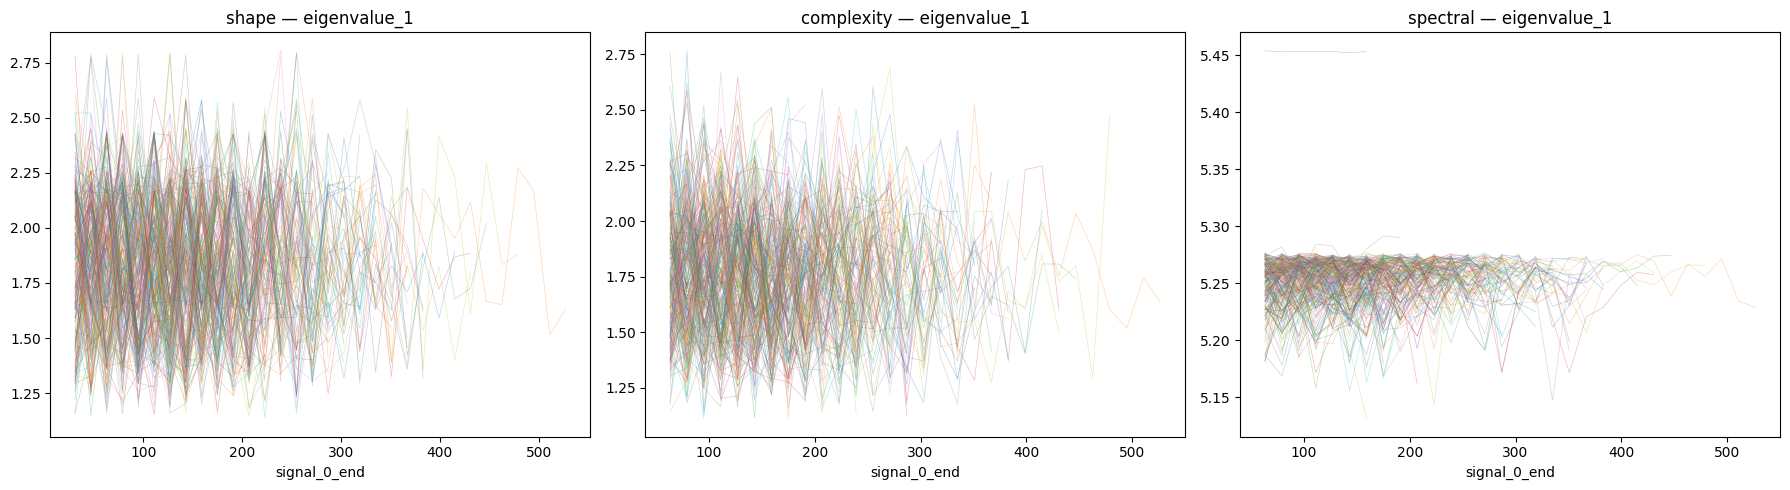

In [4]:
geo = files.get('cohort_geometry')
if geo is not None:
    engines = geo['engine'].unique() if 'engine' in geo.columns else ['all']
    fig, axes = plt.subplots(1, len(engines), figsize=(6 * len(engines), 5), squeeze=False)
    for i, eng in enumerate(engines):
        subset = geo[geo['engine'] == eng] if 'engine' in geo.columns else geo
        if 'cohort' in subset.columns:
            for cohort, grp in subset.groupby('cohort'):
                axes[0, i].plot(grp['signal_0_end'], grp['eigenvalue_1'], alpha=0.3, linewidth=0.5)
        else:
            axes[0, i].plot(subset['signal_0_end'], subset['eigenvalue_1'])
        axes[0, i].set_title(f'{eng} — eigenvalue_1')
        axes[0, i].set_xlabel('signal_0_end')
    plt.tight_layout()
    plt.show()
else:
    print('cohort_geometry not found')

## Effective Dimensionality Over Time

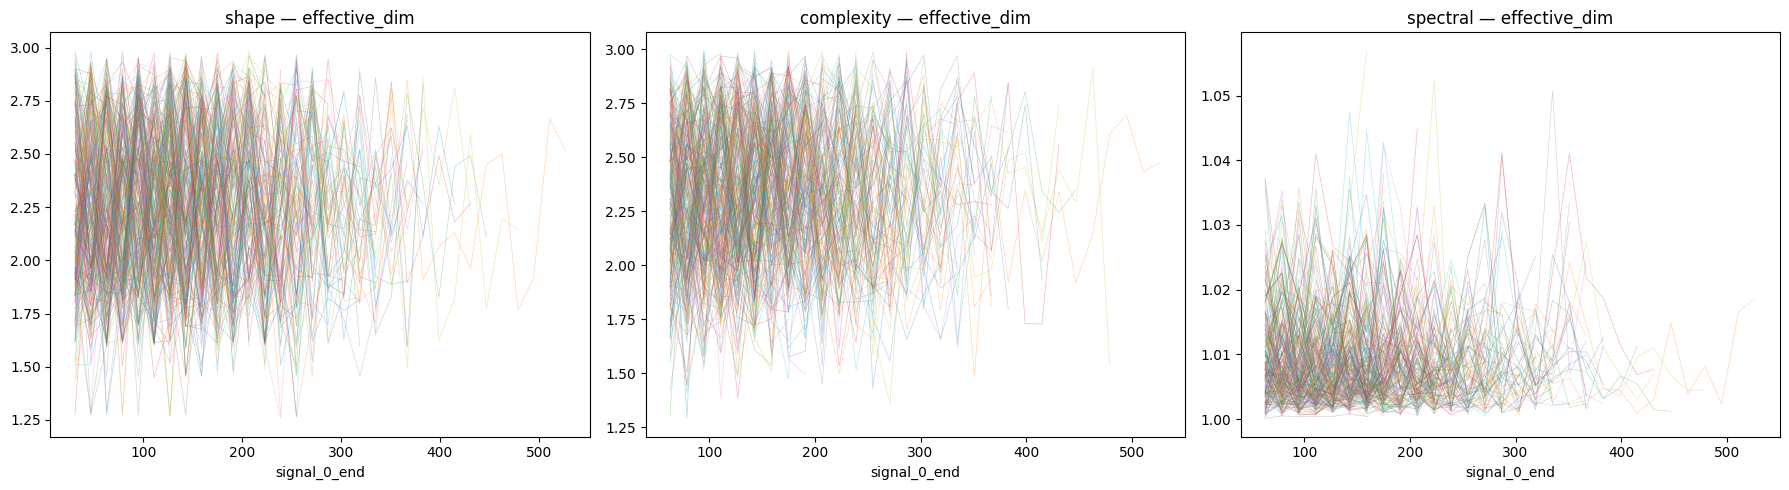

In [5]:
geo = files.get('cohort_geometry')
if geo is not None:
    engines = geo['engine'].unique() if 'engine' in geo.columns else ['all']
    fig, axes = plt.subplots(1, len(engines), figsize=(6 * len(engines), 5), squeeze=False)
    for i, eng in enumerate(engines):
        subset = geo[geo['engine'] == eng] if 'engine' in geo.columns else geo
        if 'cohort' in subset.columns:
            for cohort, grp in subset.groupby('cohort'):
                axes[0, i].plot(grp['signal_0_end'], grp['effective_dim'], alpha=0.3, linewidth=0.5)
        else:
            axes[0, i].plot(subset['signal_0_end'], subset['effective_dim'])
        axes[0, i].set_title(f'{eng} — effective_dim')
        axes[0, i].set_xlabel('signal_0_end')
    plt.tight_layout()
    plt.show()
else:
    print('cohort_geometry not found')

## Geometry Dynamics — Velocity & Jerk

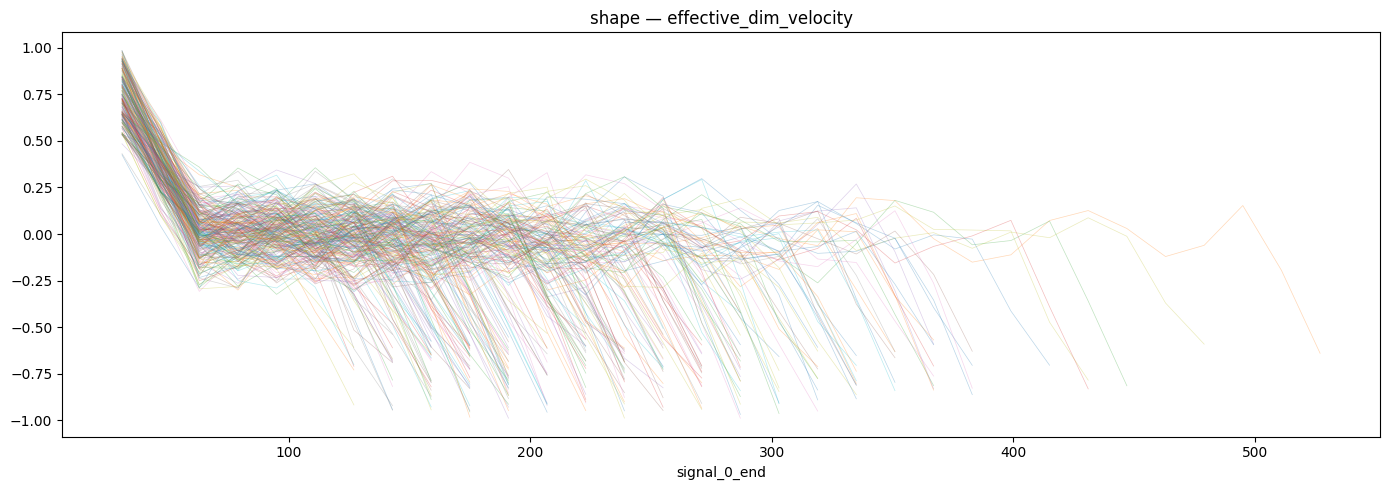

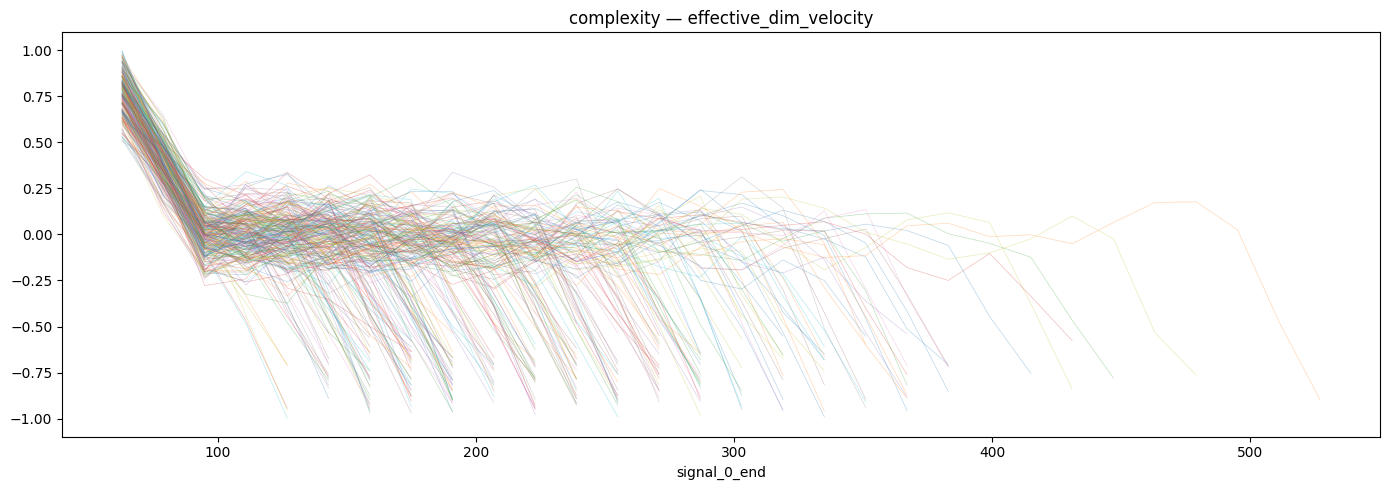

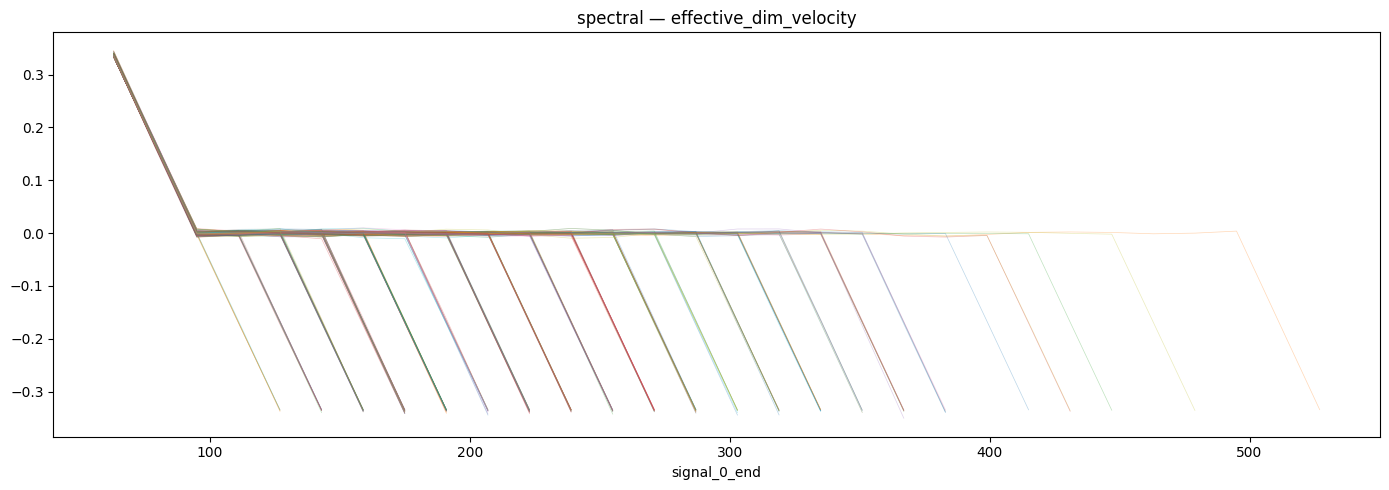

In [6]:
dyn = files.get('geometry_dynamics')
if dyn is not None:
    engines = dyn['engine'].unique() if 'engine' in dyn.columns else ['all']
    for eng in engines:
        subset = dyn[dyn['engine'] == eng] if 'engine' in dyn.columns else dyn
        vel_cols = [c for c in subset.columns if 'velocity' in c.lower() and 'jerk' not in c.lower()]
        if vel_cols and 'cohort' in subset.columns:
            fig, ax = plt.subplots(figsize=(14, 5))
            for cohort, grp in subset.groupby('cohort'):
                ax.plot(grp['signal_0_end'], grp[vel_cols[0]], alpha=0.3, linewidth=0.5)
            ax.set_title(f'{eng} — {vel_cols[0]}')
            ax.set_xlabel('signal_0_end')
            plt.tight_layout()
            plt.show()
else:
    print('geometry_dynamics not found')

## FTLE — Lyapunov Exponents

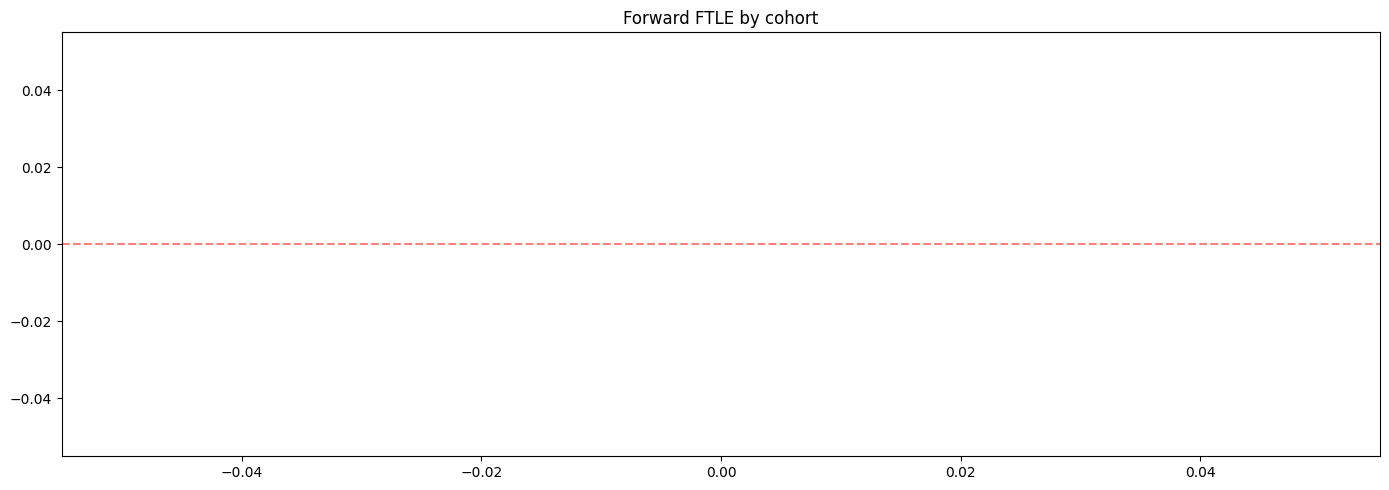


FTLE stats:
count       0
unique      0
top       NaN
freq      NaN
Name: ftle, dtype: object

Stability distribution:
stability
insufficient_data    496
unknown                2
Name: count, dtype: int64


In [7]:
ftle = files.get('ftle')
if ftle is not None:
    if 'cohort' in ftle.columns:
        fig, ax = plt.subplots(figsize=(14, 5))
        for cohort, grp in ftle.groupby('cohort'):
            ax.plot(grp.index, grp['ftle'], alpha=0.3, linewidth=0.5)
        ax.set_title('Forward FTLE by cohort')
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        ftle.plot(y='ftle', title='Forward FTLE')
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        plt.show()
    
    print(f'\nFTLE stats:')
    print(ftle['ftle'].describe())
    print(f'\nStability distribution:')
    if 'stability' in ftle.columns:
        print(ftle['stability'].value_counts())
else:
    print('ftle not found')

## Lyapunov Exponents

In [8]:
lyap = files.get('lyapunov')
if lyap is not None:
    print('Lyapunov columns:', list(lyap.columns))
    print(f'Shape: {lyap.shape}')
    print()
    lyap_col = 'lyapunov_max' if 'lyapunov_max' in lyap.columns else lyap.select_dtypes('number').columns[0]
    print(lyap[lyap_col].describe())
    if 'stability' in lyap.columns:
        print(f'\nStability:')
        print(lyap['stability'].value_counts())
else:
    print('lyapunov not found')

Lyapunov columns: ['signal_id', 'cohort', 'lyapunov', 'embedding_dim', 'embedding_tau', 'confidence', 'n_samples']
Shape: (5976, 7)

count    4008.000000
mean        0.018943
std         0.029052
min        -0.007689
25%         0.005620
50%         0.007945
75%         0.021708
max         0.210490
Name: lyapunov, dtype: float64


## Thermodynamics

In [9]:
thermo = files.get('thermodynamics')
if thermo is not None:
    print('Thermodynamics columns:', list(thermo.columns))
    print(f'Shape: {thermo.shape}')
    print()
    display(thermo.describe())
else:
    print('thermodynamics not found')

Thermodynamics columns: ['cohort', 'entropy', 'energy', 'energy_std', 'temperature', 'free_energy', 'n_samples']
Shape: (249, 7)



,entropy,energy,energy_std,temperature,free_energy,n_samples
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,4.618197,1.892945,0.676044,1.214686,-3.728333,37.746988
std,0.343057,0.059165,0.036870,0.145736,0.825417,13.638043
min,3.890066,1.719946,0.569103,0.735146,-5.668619,17.000000
25%,4.335133,1.853335,0.653713,1.119003,-4.351564,26.000000
50%,4.623544,1.892572,0.680025,1.228021,-3.765011,35.000000
75%,4.874435,1.934269,0.699689,1.311796,-3.151129,47.000000
max,5.541662,2.090507,0.776529,1.566324,-1.398760,92.000000


## System Geometry (Fleet Scale)

In [10]:
sys_geo = files.get('system_geometry')
if sys_geo is not None:
    print('System geometry columns:', list(sys_geo.columns))
    print(f'Shape: {sys_geo.shape}')
    print()
    display(sys_geo)
else:
    print('system_geometry not found (single-cohort domain?)')

System geometry columns: ['signal_0_end', 'n_cohorts', 'n_features', 'eigenvalue_1', 'eigenvalue_2', 'eigenvalue_3', 'eigenvalue_4', 'eigenvalue_5', 'explained_1', 'explained_2', 'explained_3', 'explained_4', 'explained_5', 'effective_dim', 'total_variance', 'condition_number', 'ratio_2_1', 'ratio_3_1', 'eigenvalue_entropy_norm']
Shape: (16, 19)



,signal_0_end,n_cohorts,n_features,eigenvalue_1,eigenvalue_2,eigenvalue_3,eigenvalue_4,eigenvalue_5,explained_1,explained_2,explained_3,explained_4,explained_5,effective_dim,total_variance,condition_number,ratio_2_1,ratio_3_1,eigenvalue_entropy_norm
0,79.0,249,36,8.195153,7.126335,6.551499,3.968916,1.814314,0.226729,0.197159,0.181255,0.109805,0.050195,6.941169,36.145161,1.957596e+16,0.869579,0.799436,0.634298
1,95.0,249,36,7.945870,7.567287,6.440118,4.738905,1.770480,0.219832,0.209358,0.178174,0.131108,0.048982,6.721303,36.145161,7.012951e+16,0.952355,0.810499,0.622514
2,111.0,249,36,8.177006,7.256561,6.465370,4.049871,1.921111,0.226227,0.200762,0.178872,0.112045,0.053150,6.859745,36.145161,2.276786e+16,0.887435,0.790677,0.620558
3,127.0,249,36,8.028105,7.486643,6.130243,4.862679,1.653787,0.222107,0.207127,0.169601,0.134532,0.045754,6.826377,36.145161,1.059930e+16,0.932554,0.763598,0.629179
4,143.0,244,36,8.302682,7.879783,5.846916,4.620232,1.792223,0.229685,0.217986,0.161749,0.127814,0.049580,6.646434,36.148148,3.282095e+16,0.949065,0.704220,0.622480
5,159.0,232,36,7.912660,7.430501,6.078430,3.861746,2.026581,0.218849,0.205513,0.168117,0.106808,0.056051,7.156984,36.155844,1.764301e+16,0.939065,0.768190,0.637176
6,175.0,209,36,8.424894,7.614839,6.190856,5.616555,1.742843,0.232905,0.210511,0.171145,0.155269,0.048181,6.302727,36.173077,6.346388e+17,0.903850,0.734829,0.599253
7,191.0,182,36,8.728437,7.687797,6.242064,4.607594,1.710221,0.241124,0.212377,0.172438,0.127285,0.047245,6.403424,36.198895,1.434547e+16,0.880776,0.715141,0.599859
8,207.0,153,36,9.081572,7.128144,6.052874,4.589270,1.726446,0.250617,0.196710,0.167036,0.126647,0.047643,6.518891,36.236842,1.436358e+19,0.784902,0.666501,0.613643
9,223.0,139,36,7.775189,7.670620,6.754886,5.025817,1.776288,0.214424,0.211540,0.186286,0.138602,0.048986,6.582126,36.260870,1.630829e+18,0.986551,0.868775,0.607508


## Information Flow — Granger Causality

In [11]:
info = files.get('cohort_information_flow')
if info is not None:
    print('Information flow columns:', list(info.columns))
    print(f'Shape: {info.shape}')
    print()
    # Show strongest causal pairs
    if 'granger_f_a_to_b' in info.columns:
        top = info.nlargest(10, 'granger_f_a_to_b')[['signal_a', 'signal_b', 'granger_f_a_to_b', 'granger_p_a_to_b']]
        print('Top 10 causal pairs (A -> B):')
        display(top)
else:
    print('cohort_information_flow not found')

Information flow columns: ['signal_a', 'signal_b', 'n_samples', 'granger_f_a_to_b', 'granger_p_a_to_b', 'granger_f_b_to_a', 'granger_p_b_to_a', 'transfer_entropy_a_to_b', 'transfer_entropy_b_to_a', 'dtw_distance', 'mutual_info', 'normalized_mi', 'kl_divergence_a_to_b', 'kl_divergence_b_to_a', 'js_divergence', 'is_cointegrated', 'hedge_ratio', 'half_life', 'spread_zscore', 'copula_best_family', 'kendall_tau', 'spearman_rho', 'lower_tail_dependence', 'upper_tail_dependence', 'tail_asymmetry', 'cohort']
Shape: (30927, 26)

Top 10 causal pairs (A -> B):


,signal_a,signal_b,granger_f_a_to_b,granger_p_a_to_b
17767,W32,epr,10.362931,0.001440
17776,W31,epr,10.281133,0.001503
17775,P15,epr,10.154161,0.001606
17777,P2,epr,9.916232,0.001819
17791,P30,epr,9.909116,0.001826
17750,T2,epr,8.313195,0.004247
29790,NRc,epr,8.225156,0.004382
17219,T30,epr,8.204581,0.004514
29811,BPR,epr,8.162440,0.004532
29802,NRf,epr,7.863771,0.005325


## Schema Reference — All Files

In [12]:
for name, df in sorted(files.items()):
    print(f'\n=== {name} ({df.shape[0]} rows x {df.shape[1]} cols) ===')
    for col in df.columns:
        dtype = df[col].dtype
        null_pct = 100 * df[col].isna().sum() / len(df)
        sample = df[col].dropna().iloc[0] if df[col].notna().any() else 'ALL NULL'
        if isinstance(sample, float):
            sample = f'{sample:.4f}'
        print(f'  {col:40s} {str(dtype):12s} {null_pct:5.1f}% null  sample={sample}')


=== breaks (46448 rows x 10 cols) ===
  signal_id                                object         0.0% null  sample=BPR
  cohort                                   object         0.0% null  sample=engine_1
  signal_0                                 float64        0.0% null  sample=5.0000
  magnitude                                float64        0.0% null  sample=-0.1331
  direction                                int8           0.0% null  sample=-1
  sharpness                                float64        0.0% null  sample=0.0665
  duration                                 uint32         0.0% null  sample=2
  pre_level                                float64        0.0% null  sample=9.3369
  post_level                               float64        0.0% null  sample=9.3194
  snr                                      float64        0.0% null  sample=0.1331

=== cohort_feature_loadings (34131 rows x 5 cols) ===
  signal_0_end                             float64        0.0% null  sample=31.0000
 

In [ ]:
import polars as pl
import numpy as np
import os

BASE = os.path.expanduser('~/domains/cmapss/FD_004/train')
OUT = f'{BASE}/output/system'

sigs = pl.read_parquet(f'{OUT}/trajectory_signatures.parquet')
library = pl.read_parquet(f'{OUT}/trajectory_library.parquet')
match = pl.read_parquet(f'{OUT}/trajectory_match.parquet')
obs = pl.read_parquet(f'{BASE}/observations.parquet')

print(f'Signatures: {sigs.shape}')
print(f'Library:    {library.shape}')
print(f'Match:      {match.shape}')